# ¿Cómo encontrar los grupos de riesgos para cumplimiento del artículo 54 de la CUB?

Supongamos que tenemos dos grupos de riesgo formados por las contrapartes $Grupo_1 = \{a, b, c\}$ y $Grupo_2 = \{d, e, f\}$. Estos contrapartes pueden estar relacionados por control o por interdepedencia económica conforme al artículo 52 de la CUB.

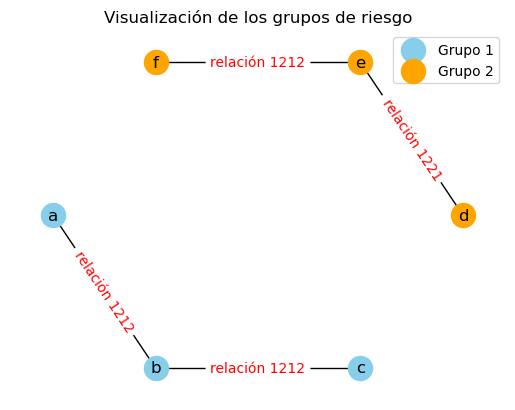

En sentido estricto, nosotros tendremos la siguiente información:

El $Grupo_1$ está formado por

-  $a$ y $b$ están relacionados por la clave 1212
-  $b$ y $c$ están relacionados por la clave 1212

El $Grupo_2$ está formado por:

-  $d$ y $e$ están relacionados por la clave 1212
-  $d$ y $f$ están relacionados por la clave 1212

Las claves están referenciadas a formulario de llenado del R35 disponible en: https://www.gob.mx/cms/uploads/attachment/file/903458/CUB_BM_BD_R35_Grandes_exposiciones_Vigencia_ISL_202310_202401_Actualizaci_n_15_de_marzo_2024.pdf

### Gráficamente se puede ver las siguientes redes:

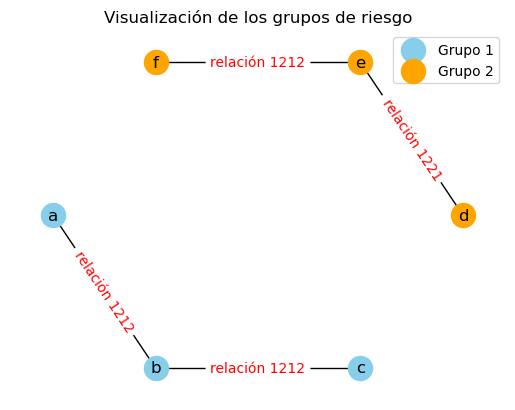

In [237]:
import networkx as nx
import matplotlib.pyplot as plt

# Definir grupos
grupo1 = ["a", "b", "c"]
grupo2 = ["d", "e", "f"]

# Crear grafo
G = nx.Graph()

# Agregar nodos con atributo de grupo
G.add_nodes_from(grupo1, group=1)
G.add_nodes_from(grupo2, group=2)

# Definir conexiones (puedes editarlas a tu gusto)
edges = [
    ("a", "b"), ("b", "c"),  ("d", "e"), ("e", "f")
]

edge_labels = {
    ("a", "b"): "relación 1212",
    ("b", "c"): "relación 1212",
    ("d", "e"): "relación 1221",
    ("e", "f"): "relación 1212"
}

G.add_edges_from(edges)

# usamos sheel para el layout
pos = nx.shell_layout( G )

# Dibujamos los edges
nx.draw_networkx_edges(G, pos)

# Dibujar nodos grupo 1 (círculos en azul)
nx.draw_networkx_nodes(G, pos, nodelist=grupo1, node_color="skyblue", node_shape="o", label="Grupo 1")

# Dibujar nodos grupo 2 (cuadrados en naranja)
nx.draw_networkx_nodes(G, pos, nodelist=grupo2, node_color="orange", node_shape="o", label="Grupo 2")

# Etiquetas
nx.draw_networkx_labels(G, pos, font_size=12, font_color="black")

nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color="red")

# Leyenda
plt.legend(scatterpoints=1)
plt.title("Visualización de los grupos de riesgo")
plt.axis("off")
plt.show()



#### No obstante, la información de la relación entre contrapartes, seguramente, se encontrará de la siguiente forma:

In [239]:
import pandas as pd
conexiones = pd.DataFrame({'Contraparte 1':['a', 'b', 'd', 'e'], 'Contraparte 2': ['b', 'c', 'e', 'f'], 'Tipo Relacion': [1212, 1212, 1221, 1212]})
conexiones

,Contraparte 1,Contraparte 2,Tipo Relacion
0,a,b,1212
1,b,c,1212
2,d,e,1221
3,e,f,1212


#### Asumimos que ya se determinaron las condiciones por la que dos contrapartes pueden estar relacionadas por control o interdependencia económica conforme al artículo 52 y 53 de la CUB.

#### A partir de está información, no es fácil observar que existe una relación entre a, b y c y otra relación entre d, e y f y mucho menos si el número de contrapartes es más amplio.

## ¿Cómo encontrar los grupos de riesgos para cumplimiento de Riesgo Común y Grandes Exposiciones

#### Primero encontraremos la matriz adyacente de la red. La matriz adyacente es una matriz cuadrada donde aparece 1 cuando se encuentra una relación y cero en otro caso

La matriz adyacente de la red anterior es:
$$\mbox{Matriz adyacente} = \left( \begin{array}
.  & a & b & c & d & e & f \\
a & 0 & 1 & 0 & 0 & 0 & 0 \\
b & 0 & 0 & 1 & 0 & 0 & 0 \\
c & 0 & 0 & 0 & 0 & 0 & 0 \\
d & 0 & 0 & 0 & 0 & 1 & 0 \\
e & 0 & 0 & 0 & 0 & 0 & 1 \\
f & 0 & 0 & 0 & 0 & 0 & 0 \\
\end{array}\right )$$

A partir de la matriz adyacente es posible identificar si el nodo $x$ está relacionado con el nodo $y$ a partir de la función $connected\_components$ de la librarua networkx.

Por ejemplo, el nodo $a$ está relacionado con el nodo $b$ porque se puede pasar, por un paso, de $a$ a $b$. Adicionalmente, está relacionado el nodo $a$ y $c$ porque existe una ruta de $a$ a $c$ pasando por $b$. Por lo que, el Grupo 1 está formado por $a, b, c$.

La primera función consisten en construir a partir del dataframe $conexiones$ la matriz adyacente. 

In [245]:
import pandas as pd    # pandas para manipular el dataframe

def matriz_ad(grupos_df):
    nodos = sorted(set(conexiones['Contraparte 1']).union(set(conexiones['Contraparte 2'])))
    matriz_ady = pd.DataFrame(0, index=nodos, columns=nodos)
    for _, fila in conexiones.iterrows():
        matriz_ady.loc[fila['Contraparte 1'], fila['Contraparte 2']] = 1
    return matriz_ady

m_adj = matriz_ad(conexiones)
m_adj

,a,b,c,d,e,f
a,0,1,0,0,0,0
b,0,0,1,0,0,0
c,0,0,0,0,0,0
d,0,0,0,0,1,0
e,0,0,0,0,0,1
f,0,0,0,0,0,0


#### Realizamos la función que permite identificar los grupos de riesgo, por lo que, utilizaremos la función $connected\_components$.

In [247]:
import networkx as nx

def id_grupos(matriz_ady):
    G = nx.from_pandas_adjacency(matriz_ady )    
    componentes = list(nx.connected_components(G)) #encuentra los grupos de riesgo tal que existe una ruta que conect a los dos nodos    
    grupos_riesgo = {f"Grupo_{i+1}": sorted(list(comp)) for i, comp in enumerate(componentes)}
    return grupos_riesgo


grupos_dic = id_grupos(m_adj)
grupos_dic

{'Grupo_1': ['a', 'b', 'c'], 'Grupo_2': ['d', 'e', 'f']}

#### Adicionalmente podemos geneerar un código que regrese la gráfica de la red, los grupos diseñados y la exposición de cada uno de los grupos.

##### Introducimos un dataframe que representa los saldos por cada contraparte:

In [250]:
saldos_df = pd.DataFrame({
                    'nodos': ["a", "b", "c", "d", "e", "f"],
                    'saldos': [1, 2, 3, 4, 5, 6] })
saldos_df

,nodos,saldos
0,a,1
1,b,2
2,c,3
3,d,4
4,e,5
5,f,6


En la siguiente función, utilizamos:
- dataframe de conexiones 
- dataframe de saldos por contraparte

Y regresa:
- diccionario de grupos
- diccionario de saldos por grupo
- gráfico de grupos para una mejor visualización

In [252]:
import networkx as nx
import matplotlib.pyplot as plt
import random
import sys

def genera_grupos(conexiones, saldos_df):
    # edges es una lista de listas o tuplas de la siguiente forma
    #    edges = [
    #              ("a", "b"), ("b", "c"),  ("d", "e"), ("e", "f")
    #            ]
    #conexiones es un dataframe con la siguiente 
    #conexiones = pd.DataFrame({'Contraparte 1':['a', 'b', 'd', 'e'], 'Contraparte 2': ['b', 'c', 'e', 'f'], 'Tipo Relacion': [1212, 1212, 1221, 1212]})
    #saldos_df es un dataframe con la siguiente estructura
    # saldos_df = pd.DataFrame({
    #                'nodos': ["a", "b", "c", "d", "e", "f"],
    #                'saldos': [1, 2, 3, 4, 5, 6]
    #})
    
    G = nx.Graph()

    matriz_ady = matriz_ad(conexiones)
    grupos_dic = id_grupos(matriz_ady)   
    
    # Agregar nodos con atributo de grupo
    for v, i in enumerate( grupos_dic.keys() ):
        G.add_nodes_from(grupos_dic[i], group=v+1)
        
    edges = conexiones[['Contraparte 1', 'Contraparte 2']].values.tolist()
    
    edges = [
        ("a", "b"), ("b", "c"),  ("d", "e"), ("e", "f")
    ]

            
    edge_labels = {
        (u, v): f"rel. {int(rel)}"
        for u, v, rel in conexiones[['Contraparte 1', 'Contraparte 2', 'Tipo Relacion']].itertuples(index=False, name=None)
    }
    
    G.add_edges_from(edges)
    
    # Posiciones para los nodos (layout automático)
    pos = nx.shell_layout( G )
    
    # Dibujar aristas
    nx.draw_networkx_edges(G, pos)
    
    # Dibujar nodos grupo 1 (círculos en azul)
    for v, i in enumerate( grupos_dic.keys() ):
        color_rgb = ( random.uniform(0,1), random.uniform(0,1), random.uniform(0,1) )    
        nx.draw_networkx_nodes(G, pos, nodelist=grupos_dic[i], node_color=[color_rgb], node_shape="o", label=i, node_size=1000)
            
    # Etiquetas
    labels = {
        row['nodos']: f"{row['nodos']} (${row['saldos']})" for _, row in saldos_df.iterrows()
    }

        
    nx.draw_networkx_labels(G, pos, labels = labels, font_size=12, font_color="black")
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color="red")
        
    # Anotaciones sobre el monto acumulado del grupo    
    for v, i in enumerate( grupos_dic.keys() ):
        texto =  i + ': $' + str( saldos_df['saldos'][saldos_df['nodos'].isin( grupos_dic[i] ) ].sum() ) 
        plt.annotate(texto, xy=(0.95, 0.05 + v*5/100), xycoords="axes fraction",fontsize=10, color="darkblue", ha="left")
    
        
    # Títulos
    plt.legend(scatterpoints=1, loc='lower left')
    plt.title("Grupos de Riesgo")
    plt.axis("off")
    plt.show()

    saldos_grupos = {}
    for i in grupos_dic.keys():
        saldos_grupos[ i ]  = saldos_df['saldos'][saldos_df['nodos'].isin( grupos_dic[ i ] ) ].sum()
    
    return grupos_dic, saldos_grupos    
    
    


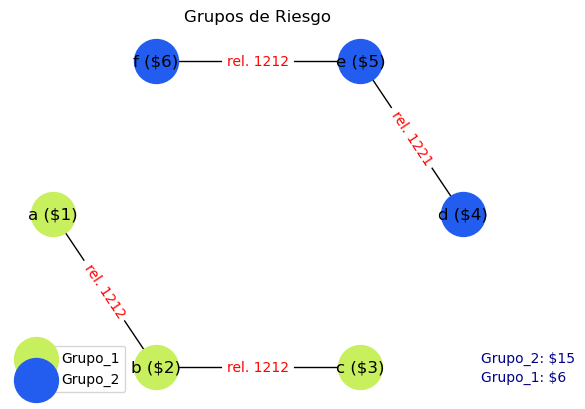

In [253]:
conexiones = pd.DataFrame({'Contraparte 1':['a', 'b', 'd', 'e'], 'Contraparte 2': ['b', 'c', 'e', 'f'], 'Tipo Relacion': [1212, 1212, 1221, 1212]})
saldos_df = pd.DataFrame({
                    'nodos': ["a", "b", "c", "d", "e", "f"],
                    'saldos': [1, 2, 3, 4, 5, 6]
})
grupos, saldos_grupo = genera_grupos(conexiones, saldos_df)

In [254]:
#observamos el diccionario de los grupos generados
grupos

{'Grupo_1': ['a', 'b', 'c'], 'Grupo_2': ['d', 'e', 'f']}

In [255]:
#observamos el diccionario de exposiciones por grupo
saldos_grupo

{'Grupo_1': 6, 'Grupo_2': 15}